In [1]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
year = 2018

# names of variables need to extract 
var_names  = ['xco2_ppm',
              'xco2_ppm_error',
              'prior_co2', # 71 levels
              'ak_co2'] # missing pressure weight function


In [10]:
# inputs for the function
directory = '/geos/u73/msadiq/co2_data/tccon.latest.public/'
filename = 'df20130720_20191101.public.nc'
ds = xr.open_dataset(directory + filename, decode_times=False)
lon = ds['long_deg'].values[0]
lat = ds['lat_deg'].values[0]
name = ds.attrs['longName']
code = ds.attrs['id']
ds #.ak_P_hPa#.prior_co2[0,:].plot()#.prior_Height

<xarray.Dataset>
Dimensions:           (ak_P_hPa: 71, ak_zenith: 16, prior_Height: 71, prior_date: 1499, time: 357486)
Coordinates:
  * time              (time) float64 1.591e+04 1.591e+04 ... 1.82e+04 1.82e+04
  * prior_date        (prior_date) float64 1.591e+04 1.591e+04 ... 1.82e+04
  * prior_Height      (prior_Height) float64 0.0 1.0 2.0 3.0 ... 68.0 69.0 70.0
  * ak_zenith         (ak_zenith) float64 10.0 15.0 20.0 25.0 ... 75.0 80.0 85.0
  * ak_P_hPa          (ak_P_hPa) float64 1.008e+03 900.9 803.1 ... 0.07 0.06
Data variables:
    zobs_km           (time) float32 ...
    zmin_km           (time) float32 ...
    year              (time) float64 ...
    xn2o_ppb_error    (time) float32 ...
    xn2o_ppb          (time) float32 ...
    xhf_ppt_error     (time) float32 ...
    xhf_ppt           (time) float32 ...
    xhdo_ppm_error    (time) float32 ...
    xhdo_ppm          (time) float32 ...
    xh2o_ppm_error    (time) float32 ...
    xh2o_ppm          (time) float32 ...
    xco_ppb_error     (time) float32 ...
    xco_ppb           (time) float32 ...
    xco2_ppm_error    (time) float32 ...
    xco2_ppm          (time) float32 ...
    xch4_ppm_error    (time) float32 ...
    xch4_ppm          (time) float32 ...
    wspd_m_s          (time) float32 ...
    wdir_deg          (time) float32 ...
    tout_C            (time) float32 ...
    sia_AU            (time) float32 ...
    pout_hPa          (time) float32 ...
    long_deg          (time) float32 -117.88 -117.88 -117.88 ... -117.88 -117.88
    lat_deg           (time) float32 34.96 34.96 34.96 ... 34.96 34.96 34.96
    hout_RH           (time) float32 ...
    hour              (time) float32 ...
    fvsi              (time) float32 ...
    day               (time) float64 ...
    azim_deg          (time) float32 ...
    asza_deg          (time) float32 ...
    GSETUP_Version    (time) |S4 ...
    GFIT_Version      (time) |S4 ...
    prior_date_index  (time) float64 ...
    prior_year        (prior_date) int32 ...
    prior_n2o         (prior_date, prior_Height) float64 ...
    prior_month       (prior_date) int32 ...
    prior_hf          (prior_date, prior_Height) float64 ...
    prior_hdo         (prior_date, prior_Height) float64 ...
    prior_h2o         (prior_date, prior_Height) float64 ...
    prior_gravity     (prior_date, prior_Height) float64 ...
    prior_day         (prior_date) int32 ...
    prior_co2         (prior_date, prior_Height) float64 ...
    prior_co          (prior_date, prior_Height) float64 ...
    prior_ch4         (prior_date, prior_Height) float64 ...
    prior_Temp        (prior_date, prior_Height) float64 ...
    prior_Pressure    (prior_date, prior_Height) float64 ...
    prior_Density     (prior_date, prior_Height) float64 ...
    ak_n2o            (ak_P_hPa, ak_zenith) float64 ...
    ak_hf             (ak_P_hPa, ak_zenith) float64 ...
    ak_hdo            (ak_P_hPa, ak_zenith) float64 ...
    ak_h2o            (ak_P_hPa, ak_zenith) float64 ...
    ak_co2            (ak_P_hPa, ak_zenith) float64 ...
    ak_co             (ak_P_hPa, ak_zenith) float64 ...
    ak_ch4            (ak_P_hPa, ak_zenith) float64 ...
Attributes:
    More_Information:            https://tccon-wiki.caltech.edu
    TCCON_Reference:             Wunch, D., G. C. Toon, J.-F. L. Blavier, R. ...
    Data_Use_Policy:             https://tccon-wiki.caltech.edu/Network_Polic...
    Auxiliary_Data_Description:  https://tccon-wiki.caltech.edu/Network_Polic...
    Software_Version:            GGG2014
    id:                          df
    longName:                    edwards01
    Contact:                     Laura T. Iraci <laura.t.iraci@nasa.gov>
    Location:                    Armstrong Flight Research Center, Edwards, C...
    Data_DOI:                    10.14291/tccon.ggg2014.edwards01.R1/1255068
    Data_Reference:              Iraci, L., J. Podolske, P. Hillyard, C. Roeh...
    Data_Revision:               R1
    creation_date:               2020/03/01
    start

In [78]:
first_day = str(year) + '-01-01'
last_day = str(year+1) + '-01-01'
# new dataarray to store daily outputs
date = np.arange(first_day, last_day, dtype='datetime64[D]')
pressure = ds.ak_P_hPa.values
daily_1d = xr.DataArray(float('nan'), coords=[date], dims=['date'])  
daily_2d = xr.DataArray(float('nan'), coords=[date,pressure], dims=['date','pressure'])


In [68]:
# position dataframe, used in for loops to locate
df_position = pd.DataFrame({'year': ds['year'], 
                            'day': ds['day'], 
                            'hour': ds['hour'],
                            'xco2': ds['xco2_ppm'],
                            'xco2_err': ds['xco2_ppm_error']})
print(len(df_position))
df_year_slice = df_position[df_position['year'] == 2018]

for iday in range(len(daily)):
    df_day_slice = df_year_slice[df_year_slice['day'] == iday+1]
    if(len(df_day_slice) != 0):
        daily[iday] = df_day_slice['xco2'].mean()


357486


In [69]:
if(sum(np.isnan(daily.values)) >= 63): print('yes')

yes


In [70]:
daily.attrs['name'] = name
daily.attrs['id'] = code
daily.attrs['lon'] = lon
daily.attrs['lat'] = lat
ds_daily = daily.to_dataset(name = 'xco2')
ds_daily.to_netcdf(directory + code + '_' + str(year) + '.nc')

In [71]:
# mass extract

In [72]:
file_dir = '/geos/u73/msadiq/co2_data/tccon.latest.public/'
file1 = open(file_dir + 'filenames', 'r')
lines = file1.readlines()

In [73]:
nm_loc = len(lines) # number of locations
loc_dict_tccon = []
daily = xr.DataArray(float('nan'), coords=[date], dims=['date']) 

for iline in range(len(lines)):
    filename = lines[iline].strip()
    
    ds = xr.open_dataset(directory + filename, decode_times=False)
    lon = ds['long_deg'].values[0]
    lat = ds['lat_deg'].values[0]
    name = ds.attrs['longName']
    code = ds.attrs['id']
    
    # position dataframe, used in for loops to locate
    df_position = pd.DataFrame({'year': ds['year'], 
                            'day': ds['day'], 
                            'hour': ds['hour'],
                            'xco2': ds['xco2_ppm'],
                            'xco2_err': ds['xco2_ppm_error']})
    #print(filename)
    
    df_year_slice = df_position[df_position['year'] == 2018]
    #print(len(df_year_slice))
    
    for iday in range(len(daily)):
        df_day_slice = df_year_slice[df_year_slice['day'] == iday+1]
        if(len(df_day_slice) != 0):
            daily[iday] = df_day_slice['xco2'].mean()
    
    if(sum(np.isnan(daily.values)) >= 30):
        daily.attrs['name'] = name
        print(filename + ' got selected')
        daily.attrs['id'] = code
        daily.attrs['lon'] = lon
        daily.attrs['lat'] = lat
        ds_daily = daily.to_dataset(name = 'xco2')
        ds_daily.to_netcdf(directory + code + '_' + str(year) + '.nc')
        loc_dict_tccon.append((name,lon,lat))

ae20120522_20181031.public.nc got selected
an20150202_20180418.public.nc got selected
bi20090301_20181001.public.nc got selected
br20100122_20190227.public.nc got selected
bu20170303_20190228.public.nc got selected


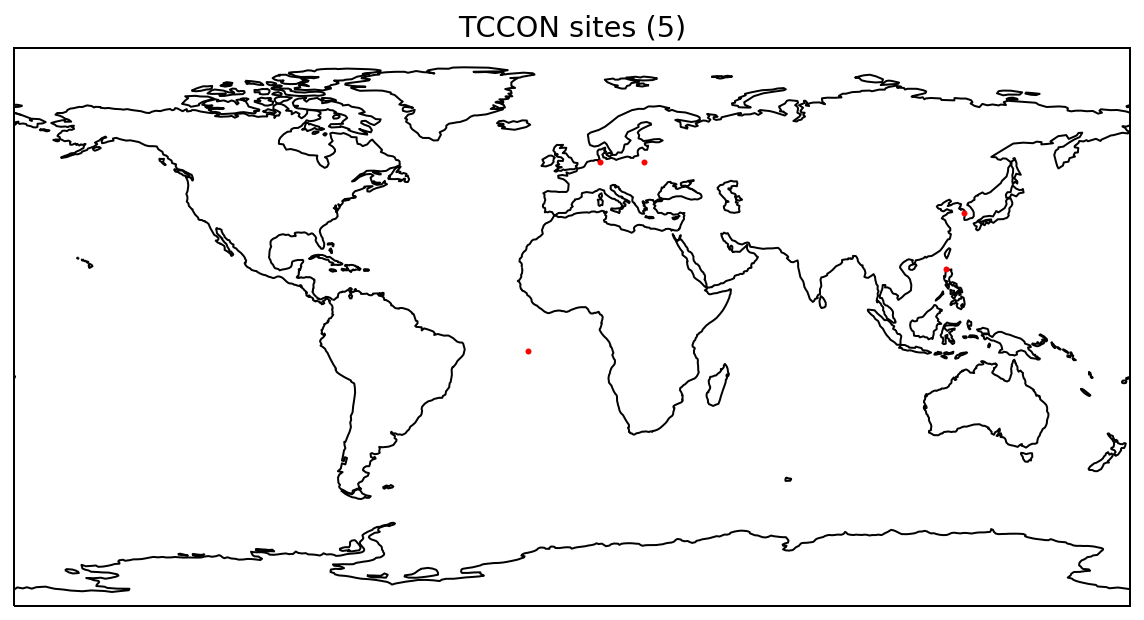

In [74]:
# plot after mapping
fig = plt.figure(figsize=[10, 7])
proj=ccrs.PlateCarree()

ax = plt.axes(projection=proj)
ax.coastlines()
ax.set_extent((-180.0, 180.0, -90., 90.0))

for name, lon, lat in loc_dict_tccon:
    plt.plot(lon, lat, marker='.', markersize=6.0, markeredgewidth=0,
                 markerfacecolor='red')

ax.set_title('TCCON sites (' + str(len(loc_dict_tccon)) + ')');

#fig.savefig(file_dir + 'noaa_locations_global.png', dpi=300)